## Mask R-CNN - Inspect Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
MODEL_PATH = os.path.join(ROOT_DIR, "resnet50_yellow.h5")

# Path to Shapes trained weights
#SHAPES_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_shapes.h5")

/home/tdteach/tools/tensorflow_py3/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)
Using TensorFlow backend.


## Configurations

In [2]:
# Run one of the code blocks

# Shapes toy dataset
# import shapes
# config = shapes.ShapesConfig()

# MS COCO Dataset
import yellow
config = yellow.XHTConfig()
XHT_DIR = "/home/tdteach/data/yellowset/release/"  # TODO: enter value here

In [3]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       None
BACKBONE_STRIDES               None
BATCH_SIZE                     1
BBOX_STD_DEV                   None
DETECTION_MAX_INSTANCES        None
DETECTION_MIN_CONFIDENCE       None
DETECTION_NMS_THRESHOLD        None
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_DIM                      128
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                None
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'class_loss': 1.0}
MASK_POOL_SIZE                 None
MASK_SHAPE                     None
MAX_GT_INSTANCES               2
MEAN_PIXEL                     None
MINI_MASK_SHAPE                None
NAME                           xiaohuangtu
NUM_CLASSES                    2

## Notebook Preferences

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [6]:
# Build validation dataset
fn_list = os.listdir(XHT_DIR)
vl_list = []
for fn in fn_list:
    if 'val' in fn:
        vl_list.append(os.path.join(XHT_DIR,fn))
print(vl_list)
dataset = yellow.XHTDataset()
dataset.load_xht(vl_list, "val")
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

['/home/tdteach/data/yellowset/release/valid.bin.0']
Images: 820
Classes: ['white', 'yellow']


## Load Model

In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = yellow.ResNet50(mode="inference", model_dir=MODEL_DIR,
                              config=config)

weights_path = MODEL_PATH
# Or, uncomment to load the last model you trained
# weights_path = model.find_last()[1]

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Loading weights  /media/tdteach/Black/workspace/Mask_RCNN/resnet50_yellow.h5


## Run Detection

image ID: 237 white
Processing 1 images
image                    shape: (128, 128, 4)         min:   -1.00000  max:    1.00000  float32
molded_images            shape: (1, 128, 128, 4)      min:   -1.00000  max:    1.00000  float32
0.03144049


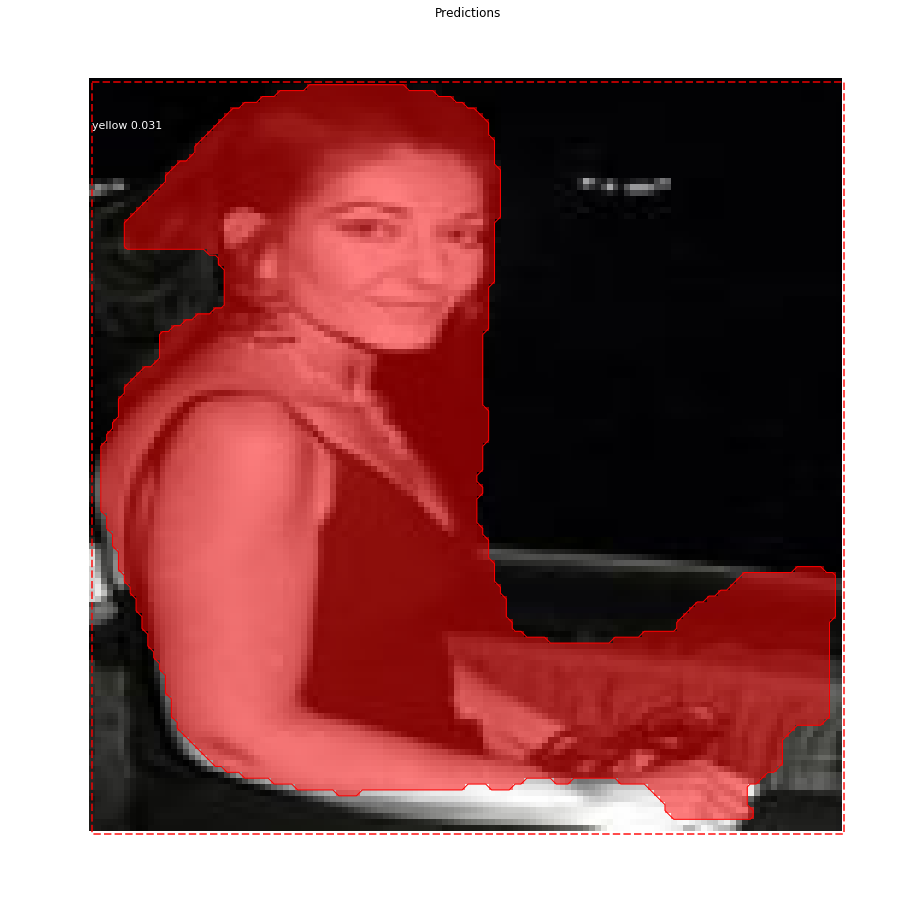

In [12]:
image_id = random.choice(dataset.image_ids)
image, gt_class_id = yellow.load_image_gt(dataset, config, image_id)
print("image ID: {} {}".format(image_id, 'yellow' if gt_class_id == 1 else 'white'))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
print(r)
img, mask = yellow.unmold_image(image)
class_ids = np.asarray([0],dtype=np.int32)
shapes = np.asarray([[0,0,128,128]])
visualize.display_instances(img, shapes, mask, class_ids, 
                            ['yellow'], [r], ax=ax,
                            title="Predictions")

### Compute ROC

AUC : 0.995356


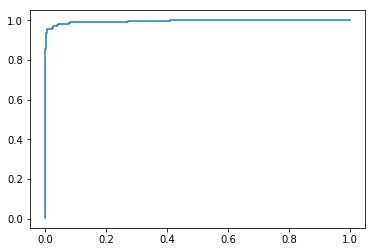

In [10]:
# Compute ROC
def get_all_result(image_ids, limit = 0):
    gt = []
    sc = []
    if limit == 0:
        limit = len(image_ids)
    for image_id in image_ids[:limit]:
        # Load image
        image, gt_class_id = yellow.load_image_gt(dataset, config, image_id)
        gt.append(gt_class_id)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        sc.append(results[0])
    return gt, sc
        

# get all results
gt, sc = get_all_result(dataset.image_ids)


from sklearn import metrics
fpr, tpr, thr = metrics.roc_curve(gt, sc)
print('AUC : %.6f' % (metrics.auc(fpr,tpr)))

import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr,tpr)
plt.show()